In [1]:
import gps_walkthrough as gpswt
import numpy as np
import matplotlib.pyplot as plt

Wave recording read. Duration: 0.1270 s


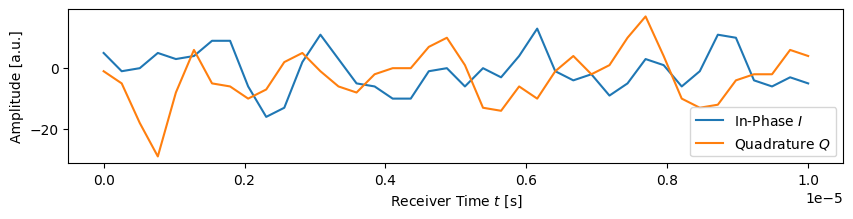

In [2]:
sampling_rate = 4.096e6

# read in the recorded radio wave file (change dtype='byte' for data from `hackrf_transfer`)
baseband = gpswt.SdrWave.from_raw_file('../recorded_data/out-1208-4096-sample.dat', sampling_rate=sampling_rate, 
                                       #, max_samples=100000000)  # limit samples for fast experiments
                                       dtype='byte') 

#baseband = gpswt.SdrWave.from_raw_file('./example-data/gps-sdr-sim-data_1byte_10MSps_10s.dat', sampling_rate=sampling_rate, 
#                                       max_samples=1000000,  # limit samples for fast experiments
#                                       dtype='byte') 

# cut the first 0.1 seconds during antenna power up (ignored)
baseband = baseband.get_interval(from_time=0.001)
print(f'Wave recording read. Duration: {baseband.duration():0.4f} s')

# visualize a snippet
t0 = 0   # select start time (0.5s)
dt = 1e-5  # time window of 5ms

signal_slice = baseband.get_interval(from_time=t0, to_time=t0+dt)
t = np.linspace(t0, t0+dt, len(signal_slice.samples))

plt.figure(figsize=(10,2))
plt.plot(t, np.real(signal_slice.samples),'-', label='In-Phase $I$')
plt.plot(t, np.imag(signal_slice.samples),'-', label='Quadrature $Q$')
plt.xlabel('Receiver Time $t$ [s]')
plt.ylabel('Amplitude [a.u.]')
plt.legend()
plt.show()

prn_id:  1  signal strength:  0.006799729026732336
Doppler Shift: -14600.0 Hz
Code Delay:    987.060546875 microseconds
Carrier Phase: 2.26 radians
prn_id:  2  signal strength:  0.006772064826353726
Doppler Shift: 12700.0 Hz
Code Delay:    92.7734375 microseconds
Carrier Phase: 0.51 radians
prn_id:  3  signal strength:  0.006803117383228528
Doppler Shift: 11500.0 Hz
Code Delay:    457.51953125 microseconds
Carrier Phase: -0.02 radians
prn_id:  4  signal strength:  0.016722705003058787
Doppler Shift: -11600.0 Hz
Code Delay:    769.775390625 microseconds
Carrier Phase: -1.57 radians
prn_id:  5  signal strength:  0.00630549858878952
Doppler Shift: 7800.0 Hz
Code Delay:    591.30859375 microseconds
Carrier Phase: 2.55 radians
prn_id:  6  signal strength:  0.028224733556964275
Doppler Shift: -10400.0 Hz
Code Delay:    268.5546875 microseconds
Carrier Phase: -1.18 radians
prn_id:  7  signal strength:  0.006633034440901161
Doppler Shift: -14400.0 Hz
Code Delay:    9.765625 microseconds
Carrie

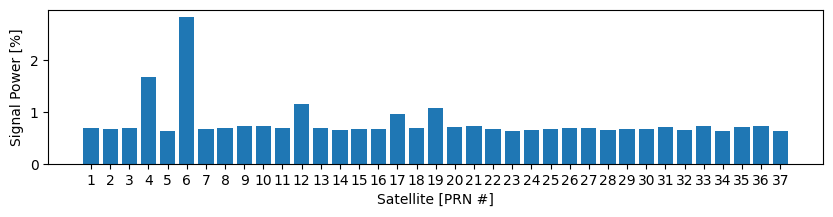

In [3]:
prn_ids = range(1, 38)  # PRN IDs to search for

signal_strength = np.zeros(len(prn_ids))
for i, prn_id in enumerate(prn_ids):
    signal_slice = baseband.get_interval(to_time=0.01)  # take first 50 ms
    #taking less because we have shorter sample.

    acq = gpswt.Acquisition(prn_id, sampling_dt=baseband.sampling_dt)
    acq_data = acq.search(signal_slice,
                          delta_freq_step=100, 
                          delta_freq_range=(-15000,15000)) # increase to 100k for HackRF w/o external clock
    
    signal_strength[i] = np.median(np.abs(acq_data['correlator']**2))  # average power
    print("prn_id: ",prn_id, " signal strength: ", signal_strength[i])
    print(f"Doppler Shift: {acq_data['delta_freq'][0]} Hz")
    print(f"Code Delay:    {acq_data['delay'][0] * 1e6} microseconds")
    print(f"Carrier Phase: {np.angle(acq_data['correlator'][0]):.2f} radians")

best_prns = np.argsort(-signal_strength)[:5] + 1
print(f'Top-5 PRNs: {best_prns}')

plt.subplots(figsize=(10,2))
plt.bar(prn_ids, signal_strength * 100, tick_label=prn_ids)
plt.xlabel('Satellite [PRN #]')
plt.ylabel('Signal Power [%]')
plt.show()
